_Jorge III Altamirano-Astorga, Luz Aurora Hernández-Martínez, Ita-Andehui Santiago-Castillejos._

_Profesor: Dr. Edgar Francisco Román-Rangel_

# Resumen

Desarrollaremos un proyecto de investigación basados en un sensor de la calidad
del aire que tenemos dentro de casa de uno de los participantes con el fin de
estudiar, analizar, explorar y entender su relación e influencia con los fenómenos
externos (calidad del aire de la ciudad y variables atmosféricas) para poder predecir la calidad del aire en el interior de casa con las mediciones de compuestos
orgánicos volátiles, los cuales tienen alta probabilidad de ser perjudiciales para
la salud.



# Introducción

El ITAM y muchos de sus miembros tenemos residencia en la Ciudad de México. Esta metrópolis es una de las más contaminadas en el continente y en el mundo. A causa de la pandemia, una gran cantidad de la población pasamos mucho de nuestro tiempo encerrados en espacios cerrados, típicamente nuestras viviendas. Queremos saber cómo influyen los factores atmosféricos y la contaminación de la Ciudad en la contaminación de un espacio cerrado.

Hemos almacenado los datos de este sensor desde Febrero 2021 tratando de mantenerlos en un área común que no tiene ventilación directa para evitar perturbaciones en las lecturas y que sea influído directamente por la contaminación exterior, así como de otras fuentes de emisión (cocina). 

Es importante destacar que este sensor no detecta contaminantes primarios, tales como: óxidos de nitrógeno (NOx), dióxido de carbono (CO2), monóxido de carbono (CO), ozono (O3), más bien mide los compuestos orgánicos volátiles, conocidos por el acrónimo anglosajón VOCs. Los VOCs típicamente son muchos de los olores que percibimos, los cuales son disoluciones de compuestos en el aire.

Estos compuestos orgánicos volátiles se han comprobado como nocivos a la salud y posibles cancerígenos, lo cual nos despertó el interés. Ejemplos de estos compuestos orgánicos son: el humo del cigarro, humo causado por cocinar alimentos, la utilización de agentes de limpieza (cloro y basados en amoniaco) y fuentes volátiles varias (como solventes, pinturas, quitaesmaltes), entre otros.

## Fuentes de Datos y Variables

Tenemos los siguientes de fuentes de datos con las siguientes variables:

1. Sensor de Contaminantes en Interior de Casa ME680: contamos aproximadamente 2.1 millones de registros. Las lecturas del sensor son cada 3 segundos.

    * Temperatura: variable numérica en grados Celsius (C) con una resolución de $0.01C$ y una precisión de $\pm 0.5C$.

    * Presión: variable numérica en hectopascales (hPa) con una resolución de $0.18~hPa$ y una precisión de $\pm 0.12~hPA$.

    * Humedad: variable numérica en porcentaje de humedad relativa (%rH) con una resolución de $0.008~\%rH$ y una precisión de $\pm 3\%rH$.

    * Resistencia del Gas: variable numérica de la resistencia eléctrica opuesta al elemento sensible del sensor medida en Ohms.

    * IAQ: variable numérica medida en el índice de calidad del aire americano en interior (IAQI, aunque utilizaremos la nomenclatura IAQ) con una resolución de $1~ IAQ$. La precisión del sensor variable que no excede 5% se guarda en una variable independiente. 

    * Precisión del sensor: variable categórica ordinal con valores en el rango de [0,3]:

        * 0: periodo de estabilización o no operativo.

        * 1-2: periodo operativo.

        * 3: precisión máxima y operación óptima.

    * Fecha y hora: variable numérica basado en UNIX/POSIX epoch que denota el tiempo desde el 01/01/1970 00:00:00.0 UTC. El tiempo está sincronizado por NTP al Centro Nacional de Metrología de México (Hora Oficial del País). 

2. Datos Abiertos del Gobierno (SINAICA) la Calidad del Aire del Gobierno de la Ciudad de México con 2,170 observaciones. Los valores reportados son  cada Hora, todos son variables continuas.

    * CO: Monóxido de Carbono medido en partes por millón (ppm).
    
    * NO, NO2, NOx: Familia de óxidos de nitrógeno. 3 variables correspondientes a la familia de óxidos de nitrógeno. Medidos en partes por billón (ppb).
    
    * O3: Ozono medido en partes por billón (ppb).
    
    * PM2.5, PM10: partículas microscópicas de 2.5 micras y 10 micras. Medido en microgramos por metro cúbico ($\mu g / m^3$)
    
    * SO2: dióxido de azufre. Medido en partes por billón (ppb).
    
    * Fecha y hora: entregado en zona horaria del Centro de México.
    
    Tomamos los datos de las estaciones meteorológicas cercanas en un radio de 10 km del sensor interior.
    


Todos los datos que tenemos fueron divididos en un set de entrenamiento y pruebas tanto para el desarrollo de los modelos predictivos, como para las imputaciones. Los datos de SINAICA se dividieron en conjuntos correspondientes a 70% de los datos y 30% para pruebas. Los datos del sensor, al ser más, utilizamos una división de 80-20.

### Problemáticas

* Datos del Gobierno de la Ciudad de México: estos datos no están siendo actualizados de manera cotidiana, por lo que en ocasiones tienen atrasos en publicar la información actual. Ejemplo, al 31 de marzo no habían subido actualizaciones desde el 28 de enero. Se pudo contrarrestar este problema utilizando la fuente de datos federal (SINAICA) que se encuentra en la bibliografía.

* No pudimos utuilizar datos meteorológicos de terceros dado que nos son fuentes abiertas y tenían un costo los datos históricos.

* Precisión y manipulación de los datos del gobierno: observamos demasiadas observaciones faltantes en todas las estaciones meteorológicas, ya sea por manipulación directa para ocultar información o bien por descuido y falta de interés del gobierno para publicar estos datos.

* Estabilidad y precisión de la toma de registros en el sensor: tuvimos típicamente interrupciones menores a 1 minuto causado por actualizaciones de software y fallas eléctricas.

* Algoritmo cerrado del sensor para convertir de la variable `gasResistance` a la variable `IAQ`; el cual es cerrado. Sólo proporcionan un objeto binario, que se puede ejecutar en Linux, Windows, ARM y ligándolo en C, el cual procesa la variable `gasResistance`. [1] [2]

    * Al parecer esta variable se genera como una serie de tiempo y llega a guardar hasta 24 hrs de estados previos de ejecución del sensor. [3]
    
    * Este código es protegido como propiedad intelectual del fabricante del sensor (Bosch), lo cual impide que se pueda hacer desensamble o ingeniería inversa.
    
    * Se pudiera utilizar el objeto binario en un ejecutable en Linux o Windows, donde pudiese ser convertida no desde el sensor, sino desde nuestras predicciones de la variable gasResistance.
    
    
    Este problema lo logramos superar robusteciendo la red neuronal para que tuviéramos las predicciones en la unidad IAQ que se describió en la sección anterior: Variables.

## Análisis Exploratorio Inicial

Se realizó un análisis exploratorio de los datos y recopilación de los datos de fuentes externas. A continuación mostramos algunas gráficas de las lecturas del sensor.

In [1]:
%matplotlib inline
from IPython.display import (display, Markdown, Image, 
                             clear_output, Latex, Math)
import pandas as pd
import re, os, sys, shelve, time, dill, io
from pickle import PicklingError
from dill import Pickler, Unpickler
shelve.Pickler = Pickler
shelve.Unpickler = Unpickler
import numpy as np
import matplotlib.pyplot as plt
from plotnine import *
import plotnine.options as p9opts
#figure_size = (6.4, 4.8)
p9opts.figure_size = (2.5, 1.2)
#p9opts.dpi = 84
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

airdata = pd.read_pickle("data/airdata/air-imputated.pickle.gz")
display(Markdown(f"* Rango de fechas obtenidas: {airdata.datetime.min().strftime('%Y-%m-%d %H:%M:%S')} al {airdata.datetime.max().strftime('%Y-%m-%d %H:%M:%S')}"))
display(Markdown(f"* Número de registros: {airdata.shape[0]:3,}"))
display(Markdown(f"* Promedio de IAQ: {airdata.IAQ.mean():.2f} desviación estándar: {airdata.IAQ.std():.2f}"))

* Rango de fechas obtenidas: 2021-02-12 06:05:35 al 2021-04-24 22:16:20

* Número de registros: 2,068,354

* Promedio de IAQ: 161.23 desviación estándar: 72.85

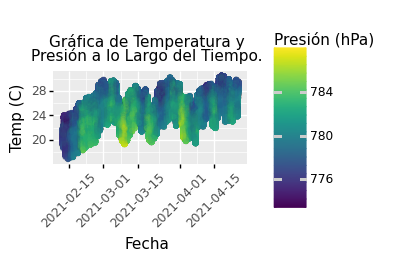

In [2]:
_ = (
    ggplot(airdata.sample(frac=0.3, random_state=175904), 
           aes(x = "datetime", y = "temperature", color="pressure")) +
    geom_jitter(alpha=0.05) +
    theme(axis_text_x=element_text(angle=45), 
          plot_title=element_text(size=11)) +
    labs(x="Fecha", y="Temp (C)", color="Presión (hPa)", 
         title="Gráfica de Temperatura y\nPresión a lo Largo del Tiempo.") 
).draw()

In [3]:
#_ = (
#    ggplot(airdata.sample(frac=0.3, random_state=175904), 
#           aes(x = "datetime", y = "IAQ", color="iaqAccuracy")) +
#    geom_jitter(alpha=0.05, size=1.25) +
#    theme(axis_text_x=element_text(angle=45)) +
#    labs(x="Fecha", color="Precisión del Sensor",
#         title="Gráfica de IAQ y Precisión\ndel Sensor a lo Largo del Tiempo")
#).draw()

## Modelos

Proponemos utilizar un modelo de aprendizaje profundo con distintos tipos de neuronas artificiales:

* DNN: Las redes neuronales densas son redes neuronales profundas que son la base para las redes neuronales artificiales (ANN) con múltiples capas entre las capas de entrada y salida.

* RNN: Las redes neuronales recurrentes son la arquitectura más clásica y utilizada para problemas de predicción de series temporales;

* CNN: red neuronal convolucional.

* LSTM: Las redes neuronales de "Memoria Largo-Corto Plazo" (LSTM) que son una evolución de las RNN desarrolladas para superar el problema del gradiente que desaparece;


* Mezcla de los mejores modelos, en este caso CNN + LSTM.

Utilizamos series de tiempo basandonos en el modelo de ventanas de tiempo donde se crearon matrices con tiempos pasados [4] [5]

Además de utilizar técnicas de series de tiempo, estadística frecuentista y bayesiana para el análisis de los datos y las imputaciones que fueron necesarias para tener esta secuencia de valores para la serie de tiempo. Exploramos las siguientes técnicas.

* KNN: K-Vecinos más cercanos.

* GLM: Métodos Lineales Generalizados: tanto frecuentista, como bayesiano con el método del muestreador de Gibbs.

* Medias

* Hot-Deck

* Interpolación con ruido.

Esta última fue la técnica que utilizamos por adecuarse mejor a la secuencia de los datos. Como se muestra en un ejemplo a continuación:

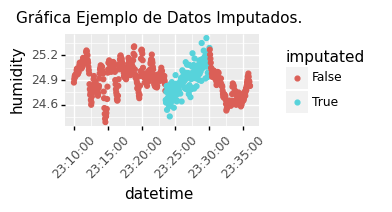

In [4]:
_ = airdata
_.index = airdata.datetime
_ = _["2021-02-18 23:10":"2021-02-18 23:35"].copy()
_["datetime2"] = _["datetime"].dt.strftime('%H:%M:%S')
#display(_)
_ = (
  ggplot(_) +
  geom_point(aes(x="datetime", y="humidity", color="imputated")) +
  scale_x_datetime(date_breaks='5 minute', date_labels="%H:%M:%S") +
  theme(axis_text_x=element_text(angle=45), 
          plot_title=element_text(size=11)) +
  labs(title="Gráfica Ejemplo de Datos Imputados.")
).draw()

# Trabajos relacionados

Existen los siguientes trabajos relacionados:

1. Examen final para la materia de "Modelos de Gran Escala" con la Prof. Liliana Millán. Utilizamos los datos de las estaciones de monitoreo ambiental de la Ciudad de México y los datos de afluencia de las estaciones Ecobici. Buscamos establecer la relación entre la afluencia de las estaciones de Ecobici y la disminución (o aumento) de contaminantes en las inmediaciones a estas estaciones. Encontramos que las estaciones con alta afluencia tienen mayor contaminación, pero pudiera ser provocado porque la afluencia es para todos los medios de transporte, incluídos los emisores de contaminación. Fueron utilizados metodos de aprendizaje máquina.

2. Development of indoor environmental index: Air quality index and thermal comfort index [6] Es un estudio de la Universidad Tecnológica de Malasia. Utilizaron los datos de un conjunto de sensores, similares al nuestro, para establecer la relación entre contaminantes en interior (IAQ) y el índice de comodidad térmica (TCI) mediante un nuevo índice de calidad y comodidad ambiental de interiores mediante un monitoreo en "tiempo real". El modelo propuesto está basado en una suma ponderada.

3. Tensorflow Tutorial on Time-Series Forecasting [4]. Los creadores del Tensorflow, a manera de demostración, utilizaron los datos de Biogeoquímica del Instituto Max-Planck de Alemania para predecir el clima a partir de datos históricos utilizando redes neuronales en combinación con series de tiempo. Utilizaron redes neuronales de los tipos RNN y LSTM.


# Solución

## Preprocesamiento 

Hicimos un preprocesamiento de los datos basado en los siguientes puntos:

* Conjunto de datos de Pruebas y Entranamiento que fue descrito en la sección de [Fuentes de Datos y Variables](#Fuentes-de-Datos-y-Variables).

* Imputación: imputamos las observaciones faltantes con datos de la calidad del aire de la Ciudad de México, en específico con la información del monitor de la estación Camarones, esto considerando su distancia a la ubicación de nuestro sensor. Para hacer la imputación usamos interpolación, aunque también exploramos KNN, MLG, entre otros. También es importante mencionar que procesamos los datos como una serie de tiempo usando un tutorial de tensorflow y Keras [5].

## Modelo Propuesto

El modelo que mejor resultados nos dio fue un modelo de redes neuronales que combina en una sola red: subredes convolucionales (CNN), memoria largo-corto plazo (LSTM) y redes densas (DNN); dado que mostró el beneficio de usarlo para la clasificación de secuencias es que pueden aprender directamente de los datos de series de tiempo sin procesar y, a su vez, no requieren experiencia en el dominio para diseñar manualmente las características de entrada. El modelo aprendió una representación interna de los datos de la serie temporal y logró el mejor rendimiento.

## Datos del Gobierno y del Sensor

En esta sección utilizaremos los datos de las estaciones de monitoreo de contaminantes de la Ciudad de México y los Datos del Sensor.

# Resultados

In [5]:
try:
  from google.colab import drive
  drive.mount('/content/drive', force_remount=False)
  from google.colab import files
except:
  ;

base_url = ""
# File Loaders
try:
    base_url = "drive/MyDrive/Colab Notebooks/Final"
    uploaded = os.path.join(base_url, "data/sinaica-imputated.pickle.gz")
    if(not os.path.isfile(uploaded)):
        from google.colab import files
        uploaded = files.upload()
except:
    base_url = ""
    uploaded = "data/sinaica/sinaica-imputated.pickle.gz"

def render_mpl_table(data, col_width=3.0, row_height=0.625, font_size=14,
                     header_color='#40466e', row_colors=['#f1f1f2', 'w'], edge_color='w',
                     bbox=[0, 0, 1, 1], header_columns=0,
                     ax=None, **kwargs):
    """
    Taken from https://stackoverflow.com/a/39358722/7323086
    """
    if ax is None:
        size = (np.array(data.shape[::-1]) + np.array([0, 1])) * np.array([col_width, row_height])
        fig, ax = plt.subplots(figsize=size)
        ax.axis('off')

    mpl_table = ax.table(cellText=data.values, bbox=bbox, colLabels=data.columns, **kwargs)

    mpl_table.auto_set_font_size(False)
    mpl_table.set_fontsize(font_size)

    for k, cell in  six.iteritems(mpl_table._cells):
        cell.set_edgecolor(edge_color)
        if k[0] == 0 or k[1] < header_columns:
            cell.set_text_props(weight='bold', color='w', size=font_size*1.05)
            cell.set_facecolor(header_color)
        else:
            cell.set_facecolor(row_colors[k[0]%len(row_colors) ])
    plt.show()

#df.dropna(inplace=True)
clear_output()

def performance_plot(history, a=None, b=None, 
                    metrics=["accuracy", "val_accuracy"],
                    plot_validation=True,
                    title="Gráficas de Desempeño."):
  """
  Prints performance plot from a, to b on a history dict.
  
  Inputs:
  history: dict containing "loss" and "accuracy" keys
  a: epoch start
  b. last epoch
  metrics: plot these metrics (train and validation). Always 2.
  plot_validation: boolean indicating if validation data should be plotted.
  a: from this epoch
  b: to this epoch    
  """
  if a is None:
      a = 0
  if b is None:
      b = len(history['loss'])
  a = np.min((a,b))
  b = np.max((a,b))

  imgrows = (len(metrics) + 1) / 2
  imgrows = np.round(imgrows, 0)
  imgrows = int(imgrows)
  #print(imgrows)

  # Plot loss
  plt.figure(figsize=(14, 5
                      *imgrows))
  plt.suptitle(title)
  plt.subplot(imgrows, 2, 1)
  plt.title('Loss')
  plt.plot(history['loss'][a:b], label='Training', linewidth=2)
  if plot_validation:
    plt.plot(history['val_loss'][a:b], label='Validation', linewidth=2)
  plt.legend()
  plt.xlabel('Epoch')
  plt.ylabel(f'Loss')
  quantiles = np.quantile(range(a, b), 
                          [.2, .4, .6, .8]).round(0).astype(int)
  quantiles = np.insert(quantiles, 0, [a])
  quantiles += 1
  quantiles = np.append(quantiles, [b-1])
  plt.xticks(ticks=quantiles-a,
              labels=quantiles)
  plt.grid(True)

  # Plot accuracy
  for i, metric in enumerate(metrics): 
    #print(f"metric: {metric}, i: {i}")
    #print(f"mean metric: {np.mean(history[metric])}")
    plt.subplot(imgrows, 2, i+2)
    plt.title(metric)
    plt.plot(history[metric][a:b], label='Training', 
              linewidth=2)
    if plot_validation:
      plt.plot(history["val_" + metric][a:b], 
                label='Validation', linewidth=2)
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel(metric)
    #plt.xlim(a, b)
    #print(range(0, b-a))
    plt.xticks(ticks=quantiles-a, 
                labels=quantiles)
    plt.grid(True)

  plt.show()

#render_mpl_table(df.head().applymap(shorten), col_width=5)

sinaica = pd.read_pickle(uploaded)
airdata = pd.read_pickle(os.path.join(base_url, "data/airdata/air-imputated.pickle.gz"))
#sinaica.head()

* Tabla Comparativa de los Datos del Gobierno y del Sensor

In [6]:
models = []
object_names = []
models_path = os.path.join(base_url, "models-sinaica")

for y in [x for x in os.listdir(models_path) if x.endswith("dill")]:
  model_path = os.path.join(models_path, y)
  with io.open(model_path, 'rb') as file:
      object_name = re.sub(r"\.", "_", y)
      object_name = re.sub(r"_dill", "", object_name)
      globals()[object_name] = dill.load(file)
      object_names.append(object_name)
#display(Markdown("Objetos cargados: \n\n>" + 
#         ", ".join(object_names)))

model_times = [o for o in object_names if o.endswith("_time")]
perf_table = pd.DataFrame({
  "Modelo": [re.sub("_time$", "", model_time) for model_time in model_times],
  "Tiempo": [globals()[model_time] for model_time in model_times]
})
df_n_params = pd.DataFrame(data={
    "Modelo": [x for x in model_n_params.keys()],
    "# Params": [x for x in model_n_params.values()]
})
perf_table = perf_table.merge(df_n_params, on="Modelo")
model_path = os.path.join(models_path, "model_n_params.dill")
model_n_params = dill.load(open(model_path, 'rb'))
model_histories = [o 
                   for o in object_names 
                   if o.endswith("_hist")
                  ]
model_metrics = [k 
                 for k in globals()[model_histories[0]].keys()
                 if re.search("^(val_|loss)", k) is None
                ]

for metric in model_metrics:
  perf_table["val_" + metric] = [np.mean(globals()[o]["val_" + metric]) for o in model_histories]
for metric in model_metrics:
  perf_table[metric] = [np.mean(globals()[o][metric]) for o in model_histories]
perf_table.rename({
  "mean_squared_logarithmic_error": "msle",
  "val_mean_squared_logarithmic_error": "val_msle"
}, axis=1, inplace=True)
perf_table.drop(["loss", "val_loss"], axis=1, inplace=True, errors='ignore')
perf_table.sort_values("val_mse", inplace=True)
perf_table["Tiempo"] = (perf_table["Tiempo"] // 60).astype('int').astype("str") + "m" + \
(perf_table["Tiempo"] % 60).round(3).apply(lambda x: f"{x:2.2f}") + "s"
perf_table.reset_index(inplace=True, drop=True)
#perf_table.round(4)
excluded_columns = ["iaqAccuracy", "datetime", "datetime-1", "delta", 
                    "imputated", "year"]
train, test = train_test_split(sinaica[[x 
                                        for x in sinaica.columns 
                                        if x not in excluded_columns]], 
                               train_size=0.8, random_state=175904, shuffle=False)
scaler_iaq = MinMaxScaler().fit(train[["IAQ"]])
perf_data_iaq = scaler_iaq.inverse_transform(perf_table.select_dtypes("float64"))
#scaler_gr = MinMaxScaler().fit(train[["gasResistance"]])
#perf_data_gr = scaler_gr.inverse_transform(perf_table.select_dtypes("float64"))
perf_data_iaq = pd.DataFrame(perf_data_iaq, 
                             columns=perf_table.select_dtypes("float64").columns)
#perf_data_gr  = pd.DataFrame(perf_data_gr, 
#                             columns=perf_table.select_dtypes("float64").columns)
perf_data_iaq.insert(0, "Tiempo", perf_table["Tiempo"], )
#perf_data_gr.insert(0,  "Tiempo", perf_table["Tiempo"], )
perf_data_iaq.insert(0, "Modelo", perf_table["Modelo"], )
#perf_data_gr.insert(0,  "Modelo", perf_table["Modelo"], )
perf_data_iaq["# Params"] = perf_table["# Params"]
#perf_data_gr["# Params"]  = perf_table["# Params"]
perf_data = perf_table.copy()
perf_data.sort_values("val_mse", inplace=True)
perf_data.reset_index(inplace=True, drop=True)
model_number_rows = [int(re.sub("[^0-9]", "", x)) for x in perf_table["Modelo"]]
#is_gr_row = [(x % 2) == 0 for x in model_number_rows]
is_iaq_row = [(x % 2) == 1 for x in model_number_rows]
#perf_data.iloc[is_gr_row] = perf_data_gr
perf_data.iloc[is_iaq_row] = perf_data_iaq
cols = ["Modelo", "Tiempo", "# Params", "val_mae", "mae"]
Markdown(perf_data.round(2)[cols].head(5).to_markdown())

|    | Modelo        | Tiempo    | # Params   |   val_mae |   mae |
|---:|:--------------|:----------|:-----------|----------:|------:|
|  0 | model_best01b | 9m34.02s  | 169,795    |     80.26 | 61.04 |
|  1 | model_lstm01  | 2m24.19s  | 54,273     |     83.18 | 52.96 |
|  2 | model_lstm03  | 6m13.69s  | 185,345    |     81.68 | 55.41 |
|  3 | model_best01a | 15m37.22s | 575,745    |     83.38 | 53.35 |
|  4 | model_conv01  | 2m53.16s  | 116,225    |     90.47 | 61.12 |

* Tabla Comparativa de los Datos del Gobierno

In [7]:
models = []
object_names = []
models_path = os.path.join(base_url, "models")

for y in [x for x in os.listdir(models_path) if x.endswith("dill")]:
  model_path = os.path.join(models_path, y)
  with io.open(model_path, 'rb') as file:
      object_name = re.sub(r"\.", "_", y)
      object_name = re.sub(r"_dill", "", object_name)
      globals()[object_name] = dill.load(file)
      object_names.append(object_name)
#display(Markdown("Objetos cargados: \n\n>" + 
#         ", ".join(object_names)))

model_times = [o for o in object_names if o.endswith("_time")]
perf_table = pd.DataFrame({
  "Modelo": [re.sub("_time$", "", model_time) for model_time in model_times],
  "Tiempo": [globals()[model_time] for model_time in model_times]
})
model_path = os.path.join(models_path, "model_n_params.dill")
model_n_params = dill.load(open(model_path, 'rb'))
#pd.DataFrame(model_n_params, columns=["# Parametros"])
df_n_params = pd.DataFrame(data={
    "Modelo": [x for x in model_n_params.keys()],
    "# Params": [x for x in model_n_params.values()]
})
perf_table = perf_table.merge(df_n_params, on="Modelo")
#df_n_params = perf_table.pop("# Params")
#perf_table.insert(2, "# Params", df_n_params)
model_histories = [o 
                   for o in object_names 
                   if o.endswith("_hist")
                  ]
model_metrics = [k 
                 for k in globals()[model_histories[0]].keys()
                 if re.search("^(val_|loss)", k) is None
                ]

for metric in model_metrics:
  perf_table["val_" + metric] = [np.mean(globals()[o]["val_" + metric]) for o in model_histories]
for metric in model_metrics:
  perf_table[metric] = [np.mean(globals()[o][metric]) for o in model_histories]
perf_table.rename({
  "mean_squared_logarithmic_error": "msle",
  "val_mean_squared_logarithmic_error": "val_msle"
}, axis=1, inplace=True)
perf_table.drop(["loss", "val_loss"], axis=1, inplace=True, errors='ignore')
perf_table.sort_values("val_mse", inplace=True)
perf_table["Tiempo"] = (perf_table["Tiempo"] // 60).astype('int').astype("str") + "m" + \
(perf_table["Tiempo"] % 60).round(3).apply(lambda x: f"{x:2.2f}") + "s"
perf_table.reset_index(inplace=True, drop=True)
#perf_table.round(4)
excluded_columns = ["iaqAccuracy", "datetime", "datetime-1", "delta", 
                    "imputated", "year"]
train, test = train_test_split(airdata[[x 
                                        for x in airdata.columns 
                                        if x not in excluded_columns]], 
                               train_size=0.8, random_state=175904, shuffle=False)
scaler_iaq = MinMaxScaler().fit(train[["IAQ"]])
perf_data_iaq = scaler_iaq.inverse_transform(perf_table.select_dtypes("float64"))
#scaler_gr = MinMaxScaler().fit(train[["gasResistance"]])
#perf_data_gr = scaler_gr.inverse_transform(perf_table.select_dtypes("float64"))
perf_data_iaq = pd.DataFrame(perf_data_iaq, 
                             columns=perf_table.select_dtypes("float64").columns)
#perf_data_gr  = pd.DataFrame(perf_data_gr, 
#                             columns=perf_table.select_dtypes("float64").columns)
perf_data_iaq.insert(0, "Tiempo", perf_table["Tiempo"], )
#perf_data_gr.insert(0,  "Tiempo", perf_table["Tiempo"], )
perf_data_iaq.insert(0, "Modelo", perf_table["Modelo"], )
perf_data_iaq["# Params"] = perf_table["# Params"]
#perf_data_gr["# Params"]  = perf_table["# Params"]
#perf_data_gr.insert(0,  "Modelo", perf_table["Modelo"], )
perf_data2 = perf_table.copy()
perf_data2.sort_values("val_mse", inplace=True)
perf_data2.reset_index(inplace=True, drop=True)
model_number_rows = [int(re.sub("[^0-9]", "", x)) for x in perf_table["Modelo"]]
#is_gr_row = [(x % 2) == 0 for x in model_number_rows]
is_iaq_row = [(x % 2) == 1 for x in model_number_rows]
#perf_data.iloc[is_gr_row] = perf_data_gr
perf_data2.iloc[is_iaq_row] = perf_data_iaq
cols = ["Modelo", "Tiempo", "# Params", "val_mae", "mae"]
perf_data2 = perf_data2.iloc[is_iaq_row]
Markdown(perf_data2.round(2)[cols].head(5).to_markdown())

|    | Modelo        | Tiempo   | # Params   |   val_mae |   mae |
|---:|:--------------|:---------|:-----------|----------:|------:|
|  1 | model_dnn01   | 1m40.90s | 4,609      |     74.06 | 61.15 |
|  2 | model_best03a | 14m0.58s | 485,633    |     75.94 | 55.8  |
|  8 | model_conv01  | 14m3.57s | 294,401    |    127.78 |  5.79 |
|  9 | model_conv03  | 6m33.58s | 419,841    |    129.51 |  6.13 |
| 12 | model_best03b | 8m50.63s | 162,115    |    164.43 |  9.28 |

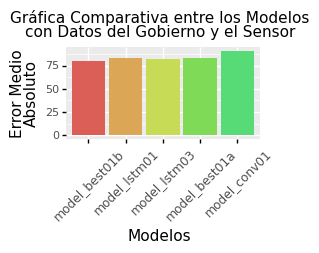

In [8]:
Modelos_list = perf_data["Modelo"].tolist()
Modelos = pd.Categorical(perf_data["Modelo"], 
                         categories=Modelos_list)
perf_data["Modelo2"] = Modelos
_ = (
  ggplot(perf_data.head(5), aes(x="Modelo2", y="val_mae", fill="Modelo2")) +
  geom_bar(stat="identity") +
  #geom_bar(aes(y="mae"), stat="identity") +
  labs(y="Error Medio\nAbsoluto", x="Modelos", 
       title="Gráfica Comparativa entre los Modelos\ncon Datos del Gobierno y el Sensor"
      ) +
  theme(legend_position="none", axis_text_x=element_text(rotation=45), 
        axis_text_y=element_text(size=8),
        plot_title=element_text(size=11),
       )
).draw()

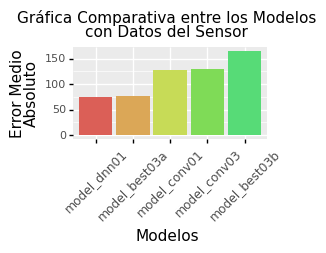

In [9]:
Modelos_list = perf_data2["Modelo"].tolist()
Modelos = pd.Categorical(perf_data2["Modelo"], 
                         categories=Modelos_list)
perf_data2["Modelo2"] = Modelos
perf_data["src"]  = "Sensor-Gov"
perf_data2["src"] = "Sensor"
_ = (
  ggplot(perf_data2.head(5), aes(x="Modelo2", y="val_mae", fill="Modelo2")) +
  geom_bar(stat="identity") +
  #geom_bar(aes(y="mae"), stat="identity") +
  labs(y="Error Medio\nAbsoluto", x="Modelos", 
       title="Gráfica Comparativa entre los Modelos\ncon Datos del Sensor"
      ) +
  theme(legend_position="none", axis_text_x=element_text(rotation=45), 
        axis_text_y=element_text(size=8),
        plot_title=element_text(size=11),) 
).draw()

# Conclusiones

Buscaremos explicar nuestras conclusiones del análisis de:

* Análisis  exploratorios sobre los datos.

* Nuestras hipótesis y sus resultados.

* Nuestras pruebas con modelos de redes neuronales profundas y el procesamiento de señales.

* Los inconvenientes que encontramos y la influencia que ejercieron sobre el presente proyecto.

    * Que no tuviéramos todos los datos disponibles en el sitio de la SINAICA nos complicó muchísimo no poder tener más datos.
    
    * El algoritmo propietario (cerrado) para calcular la variable IAQ a partir del sensor de la resistencia eléctrica en el aire hizo que perdiéramos tiempo en probar cuál de las variables era más viable predecir.
    
    * Aunque _a caballo regalado no se le ve el diente_: Los tiempos y capacidades de Google Colab no son los mejores, aún con Pro (que es bastante económico). Además de que su velocidad de desempeño es aleatoria durante diferentes momentos.
    
    * Las fuentes externas no siempre son confiables, gratuitas o completas. Nos hubiera gustado tener una fuente de datos de clima gratuita y que fuera confiable.

* Aprendizajes obtenidos durante el presente.

    * Nunca se debe subestimar la necesidad (y el tiempo que toma) de limpiar, explorar, imputar, "corregir" los datos.
    
    * Cualquier mejora en tiempos conlleva un reto, a veces grande; tal como vimos en los miniproyectos y se comentó en clase. 
    
    * No podemos confiar en que el gobierno o un ente externo entregue los datos a tiempo. Entendimos que es importante tener desde la fundación de un proyecto al menos con el 70% de los datos disponibles, para empezar a trabajar con ellos.
    
    * Nunca subestimar las fuentes bibliográficas oficiales (en nuestro caso Keras y Tensorflow) como guías prácticas y bien escritas. Dado que muchas veces Stackoverlow no tiene las mejroes respuestas. [4], [5]
    
    * No tener miedo a aprender y a leer es vital para estar actualizado: pues muchas veces cambia mucho las APIs, nuevos "approaches".
    
    * Nos resultó muy útil tener un modelo baseline [5] que fue como una hipótesis nula, que nos permitió saber qué hacía un modelo vacío. Es bueno tener esta comparación y la rescatamos como valiosa.
    
    * Los detalles y el cuidado de estos son de suma importancia: 
    
    i. Aprendimos que escalamos los datos, pero devolverlos a una escala real, es otra cosa.
    
    ii. Cuidar las semillas para hacer lo más reproducible es crítico.
    
    iii. En nuestro caso fue importante cuidar que ninguna manipulación (como el `train_test_split` no hiciera `shuffle` o barajeara el orden.
    
    iv. Es importante probar, probar y probar: alterando 1 solo detalle de la arquitectura, un hiperparámetro, una modificación de los datos, etc. Esto involucra hacer modelos constructivos, no hacerlos complejos desde un inicio.
    
* Siguientes pasos que nos surgieron:

    i. Tomar datos por al menos 1 año, para establecer más claramente la estacionalidad, incorporar (comprar) fuentes de datos del clima y contaminantes, tener más puntos de redundancia (no depender únicamente de 1 sensor en 1 sólo lugar).
    
    ii. Explorar mejores opciones para imputar datos secuenciales o series de tiempo.
    
    iii. Realizar más pruebas sobre las predicciones y ver cómo van las mediciones.
    
    iv. Hacer las pruebas con mayor capacidad de cómputo: tener ventanas más grandes en `timeseries_dataset_from_array`. Que se nos ocurría extender o reescribir esta función de Keras promediando por ejemplo a 1 min, en vez de estar probando.
    
    v. Realizar más _Hyperparameter Tuning_ (Learning Rate, combinar optimizadores en los modelos), buscar datos preentrenados, o entrenar la red con datos como el del ejemplo (del Departamento de Biogeoquímica del Instituto Max-Planck) [4] [5].
    
    vi. Hacer un tablero o que las predicciones sean predecibles por algún API.
    
    vii. Realizar predicciones con algún intervalo de confianza o grado de certidumbre de la predicción.
    
    viii. Mejorar el desempeño, que claramente no es el mejor.
    
    ix. Venderlo o publicarlo en algún journal.





# Bibliografía

* [1] [Bosch Sensortec Community | How do I convert BME 680 gas resistance to IAQ?](https://community.bosch-sensortec.com/t5/Question-and-answers/How-do-I-convert-BME680-gas-resistance-to-IAQ/qaq-p/9050/comment-id/94#M94).

* [2] [Bosch SensorTec Comunity | Solution to IAQ accuracy definition](https://community.bosch-sensortec.com/t5/MEMS-sensors-forum/BME680-IAQ-accuracy-definition/m-p/5931/highlight/true#M10).

* [3] [GitHub | Daniel Mancuso: Código fuente de OhmTech-io/uThingVOC Src/main.c](https://github.com/ohmtech-io/uThingVOC/blob/f345fdbef6a4fd0da77289b436e3c478706572a2/Src/main.c#L139)

* [4] Keras contributors et al. [Keras / Code examples / Timeseries / Timeseries forecasting for weather prediction](https://keras.io/examples/timeseries/timeseries_weather_forecasting/). 2021.

* [5] Tensorflow Contributors. [Tensorflow: Tutorial on Time series forecastingTime series forecasting](https://www.tensorflow.org/tutorials/structured_data/time_series). 2021.

* [6] Saadi S. M., et al. Development of indoor environmental index: Air quality index and thermal comfort index. 2017. [doi:10.1063/1.4975276](https://doi.org/10.1063/1.4975276).

* [Bosch BME680 Datasheet](https://www.bosch-sensortec.com/media/boschsensortec/downloads/datasheets/bst-bme680-ds001.pdf). 2021.

* Mancuso, Daniel. [Indoor Air Quality Monitor | Hackster.io](https://www.hackster.io/damancuso/indoor-air-quality-monitor-b181e9). 2019.

* [Dirección de Monitoreo Atmosféerico de la Secretaría del Medio Ambiente del Gobierno de la Ciudad de México](http://www.aire.cdmx.gob.mx/).

* [Sistema Nacional de Información de la Calidad del Aire del Gobierno Federal México](https://sinaica.inecc.gob.mx/).



* Pedregosa, Fabian; et al. [Scikit-learn: Machine Learning in Python](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html). 2021.

* Abadi, Martín, et al. [TensorFlow: Large-scale machine learning on heterogeneous systems](https://tensorflow.org). 2015. 

* McKinney, Wes. [Data structures for statistical computing in python](https://conference.scipy.org/proceedings/scipy2010/pdfs/mckinney.pdf). 2010.

* Harris, Charles, et al. Array programming with NumPy. 2021. [doi:10.1038/s41586-020-2649-2](https://doi.org/10.1038/s41586-020-2649-2).

* Hunter, John. Matplotlib: A 2D Graphics Environment. 2007. [doi:10.5281/zenodo.592536/zenodo.592536](https://doi.org/10.5281/zenodo.592536https://doi.org/10.5281/zenodo.592536).

* Román-Rangel, Francisco. Notas y Código del Curso de Aprendizaje Profundo. 2021.

* González-Pérez, Felipe. [Notas de aprendizaje de máquina](https://lucid-torvalds-517e78.netlify.app/). 2020.
 
* Mohd, Faizy. [StackOverflow AI: How to use CNN for making predictions on non-image data?](https://ai.stackexchange.com/a/10449). 2021.

* Ondris, Ladislav. [StackOverflow: How to apply CNN algorithm in python for non image dataset.](https://stackoverflow.com/a/64326002/7323086) 2020.

* Shady, Slim. [Convolutional Neural Network With Tensorflow and Keras](https://medium.com/geekculture/introduction-to-convolutional-neural-network-with-tensorflow-and-keras-cb52cdc66eaf). 2021.

* Keras contributors et al. [Keras API Reference: fit](https://keras.rstudio.com/reference/fit.html). 2021.

* Keras contributors et al. [Keras API Reference: Convolution Layers > Convolution1D](https://keras.io/api/layers/convolution_layers/convolution1d/). 2021.

* Pedregosa, Fabian; et al. [Scikit-learn: Machine Learning in Python](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html). 2021.

* Abadi, Martín, et al. [TensorFlow: Large-scale machine learning on heterogeneous systems](https://tensorflow.org). 2015. 

* McKinney, Wes. [Data structures for statistical computing in python](https://conference.scipy.org/proceedings/scipy2010/pdfs/mckinney.pdf). 2010.

* Harris, Charles, et al. Array programming with NumPy. 2021. [doi:10.1038/s41586-020-2649-2](https://doi.org/10.1038/s41586-020-2649-2)

* Hunter, John. Matplotlib: A 2D Graphics Environment. 2007. [doi:10.5281/zenodo.592536/zenodo.592536](https://doi.org/10.5281/zenodo.592536https://doi.org/10.5281/zenodo.592536)